In [13]:
library(ggplot2)
library(dplyr)
library(ggpmisc)
library(MASS)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggpp


Attaching package: 'ggpp'


The following object is masked from 'package:ggplot2':

    annotate



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




# Generate Simulation Data

In [15]:
generate.data <- function(n, each, order = c(0,1,2), random = c(0,0,0,0)) {
    k.g <- 1
    k.h <- 2
    s <- ifelse(length(each) == 1, each, length(each))
    l <- ifelse(length(each) == 1, n*n*each, sum(each))
    if (length(each) == 1) {
        group <- rep(1:(n*n), each = each)
    } else {
        group <- rep(1:(n*n), each)
    }
    X <- mvrnorm(l, rep(0, k.g + k.h), diag(1, k.g + k.h, k.g + k.h))
    for (i in 1:(n*n)) {
        group.i <- which(group == i)
        X[group.i,1] <- mean(X[group.i,1])
    }
    X <- cbind(1, X)
    positions.data <- matrix(0, l, 2)
    positions.beta <- matrix(0, n*n, 2)
    for (i in 1:n) {
        for (j in 1:n) {
            p1 = (i - 1)*n + j
            positions.beta[p1,] = c(i,j)
            for (k in 1:each[p1]) {
                p2 = ifelse(p1 > 1, sum(each[1:(p1 - 1)]) + k, k)
                positions.data[p2,] = c(i,j)
            }
        }
    }
    beta.g <- matrix(0, n*n, k.g)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.g = order[2]
            for (o1 in 0:order.g) {
                for (o2 in 0:order.g) {
                    set.seed(200 + i + j)
                    beta = beta + i^o1 * j^o2 #rnorm(1) * i^o1 * j^o2
                }
            }
            beta.g[p, 1] = 10 * beta / (n^(2*order.g))
        }
    }
    beta.g[, 1] = scale(beta.g[, 1] + random[2] * rnorm(n*n, sd = 0.1))
    beta.h <- matrix(0, n*n, k.h)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.h = order[3]
            for (o1 in 0:order.h) {
                for (o2 in 0:order.h) {
                    set.seed(300 + i * n + j)
                    beta = beta + rnorm(1) * i^o1 * j^o2
                }
            }
            beta.h[p, 1] = beta / (n^(2*order.h))
        }
    }
    set.seed(12)
    beta.h[, 1] = scale(beta.h[, 1] + random[3] * rnorm(n*n, sd = 0.1))
    set.seed(13)
    beta.h[, 2] = 1 + random[4] * rnorm(n*n, sd = 1)
    beta.intercept <- numeric(n*n)
    for (i in 1:n) {
        for (j in 1:n) {
            p = (i - 1)*n + j
            beta = 0
            order.intercept = order[1]
            for (o1 in 0:order.intercept) {
                for (o2 in 0:order.intercept) {
                    set.seed(100 + i + j)
                    beta = beta + i^o1 * j^o2 #rnorm(1) * i^o1 * j^o2
                }
            }
            beta.intercept[p] = beta / (n^(2*order.intercept))
        }
    }
    set.seed(10)
    beta.intercept = scale(beta.intercept + random[1] * rnorm(n*n, sd = 0.1))
    beta <- cbind(beta.intercept, beta.g, beta.h)
    y <- numeric(l)
    for (i in 1:(n*n)) {
        beta.i <- beta[i,]
        group.i <- which(group == i)
        X.i <- X[group.i,]
        y[group.i] <- X.i %*% beta.i
    }
    y = y + rnorm(l)
    data <- as.data.frame(cbind(group, positions.data, y, X[,-1]))
    colnames(data) <- c("group", "lon", "lat", "y", paste0(rep("g", k.g), 1:k.g), paste0(rep("h", k.h), 1:k.h))
    beta <- as.data.frame(cbind(positions.beta, beta))
    colnames(beta) <- c("lon", "lat", "Intercept", paste0(rep("g", k.g), 1:k.g), paste0(rep("h", k.h), 1:k.h))
    list(
        data = data,
        beta = beta
    )
}

In [6]:
oi = 2
og = 2
oh = 2
ri = 0
rg = 0
rh1 = 1
rh2 = 0
set.seed(100)
gen.each <- floor(runif(15*15, min = 10, max = 50))
gen <- generate.data(15, gen.each, order = c(oi, og, oh), random = c(ri, rg, rh1, rh2))
data.group <- gen$data %>% group_by(group) %>% summarise(g1 = mean(g1), lon = mean(lon), lat = mean(lat)) %>% as.data.frame()

In [7]:
write.table(gen$data["y"], "../data/hlmgwr_y.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h1")]), "../data/hlmgwr_z.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h2")]), "../data/hlmgwr_x.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$data["group"] - 1, "../data/hlmgwr_group.csv", sep = ",", row.names = F, col.names = F)
write.table(data.group[c("lon", "lat")], "../data/hlmgwr_u.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, data.group["g1"]), "../data/hlmgwr_g.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$beta, "../data/hlmgwr_beta.csv", sep = ",", row.names = F, col.names = F)

In [8]:
write.table(gen$data["y"], "../data/hlm_y.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, gen$data[c("h1", "h2")]), "../data/hlm_x.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$data["group"] - 1, "../data/hlm_group.csv", sep = ",", row.names = F, col.names = F)
write.table(data.group[c("lon", "lat")], "../data/hlm_u.csv", sep = ",", row.names = F, col.names = F)
write.table(cbind(1, data.group["g1"]), "../data/hlm_g.csv", sep = ",", row.names = F, col.names = F)
write.table(gen$beta, "../data/hlm_beta.csv", sep = ",", row.names = F, col.names = F)

# Check Results

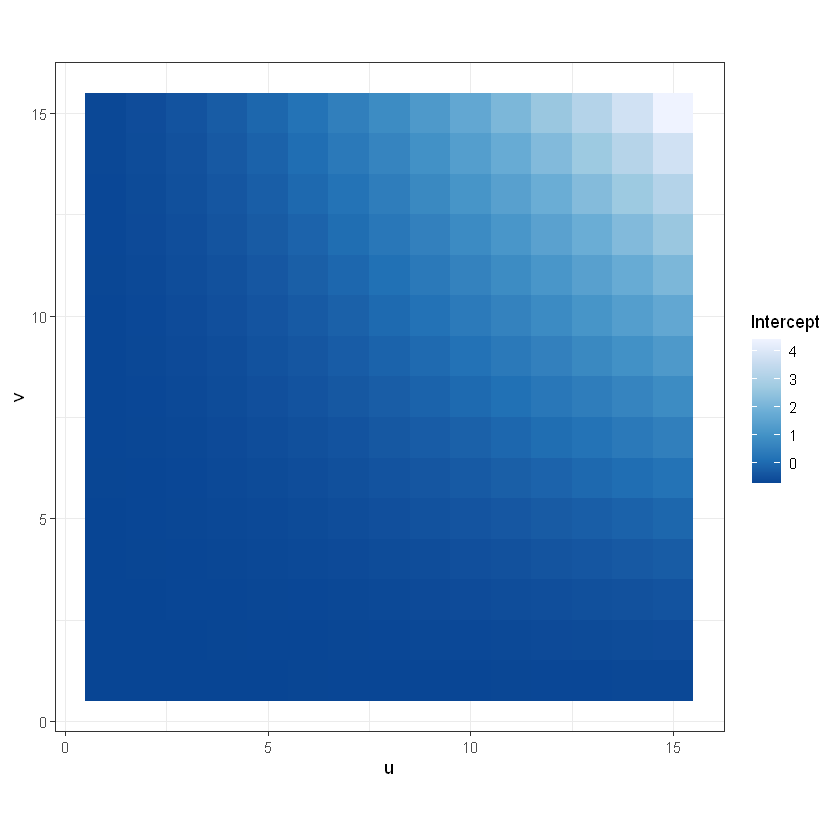

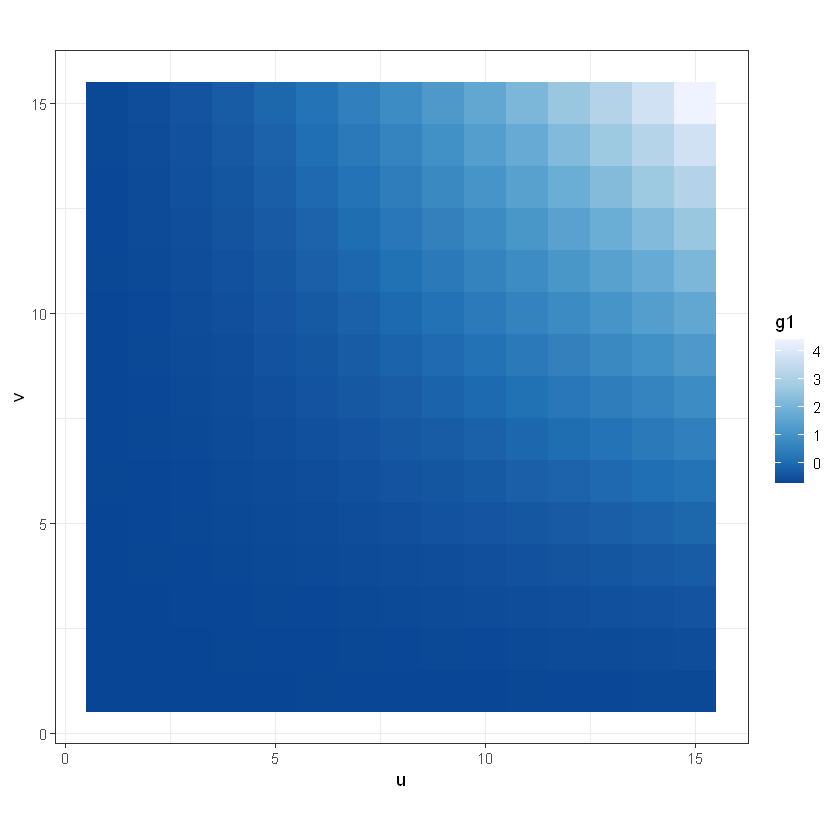

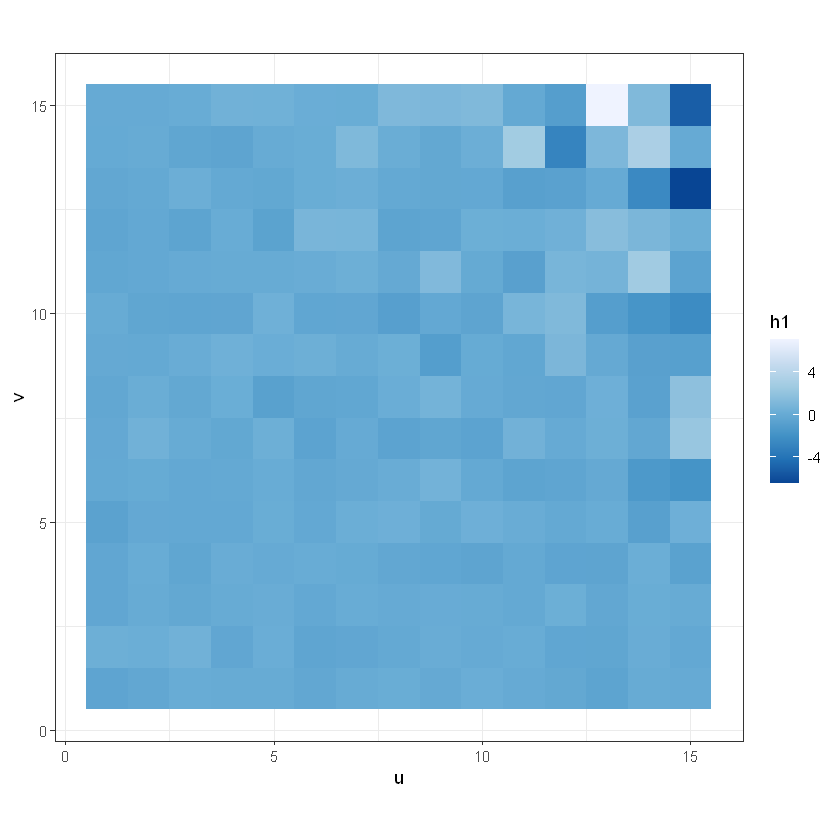

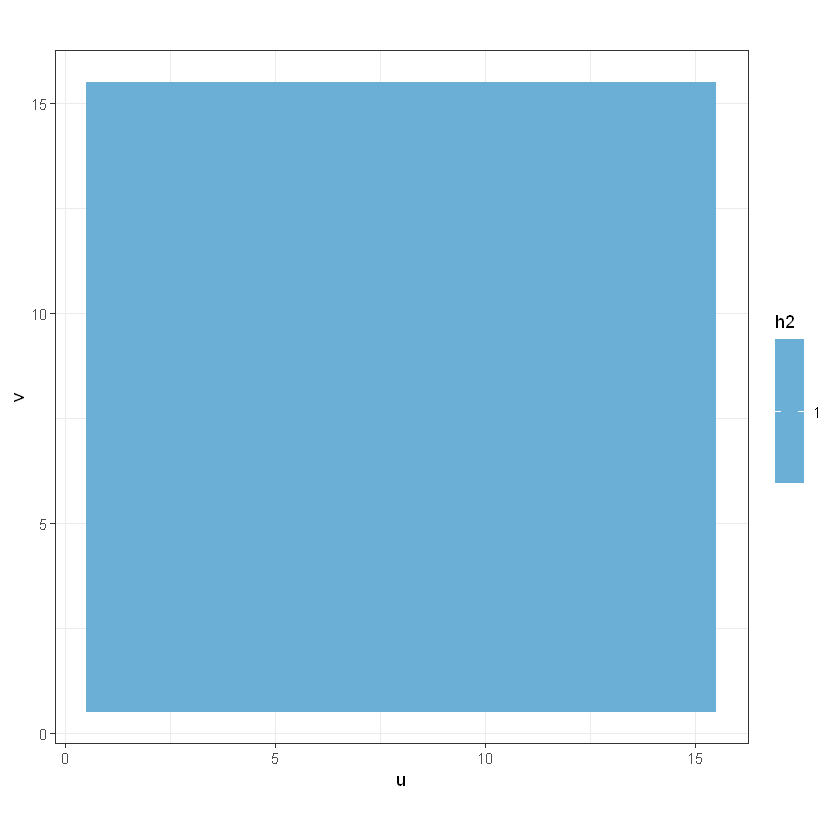

In [24]:
beta0 = read.csv("../data/hlmgwr_beta.csv", header = F)
colnames(beta0) <- c("u", "v", "Intercept", "g1", "h1", "h2")
beta0 %>%
    ggplot(aes(u, v, fill = Intercept)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = g1)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = h1)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()
beta0 %>%
    ggplot(aes(u, v, fill = h2)) + 
    geom_tile() + scale_fill_distiller() + 
    coord_fixed() + 
    # facet_wrap(~Name, nrow = 1) + 
    theme_bw()

## HLM

# R2 for Mixed Models

  Conditional R2: 0.741
     Marginal R2: 0.236

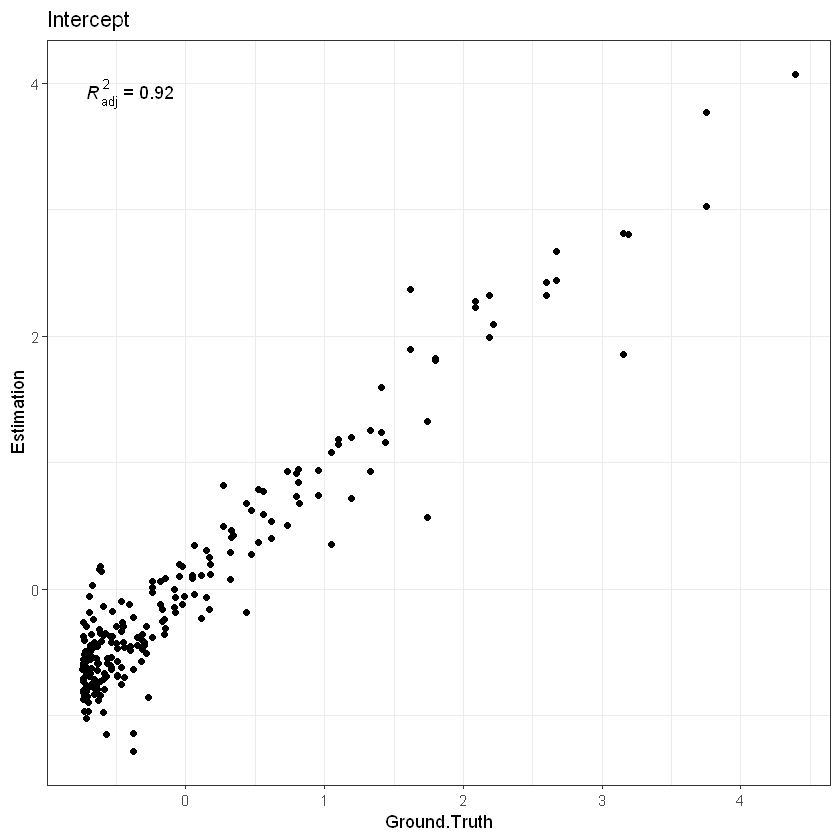

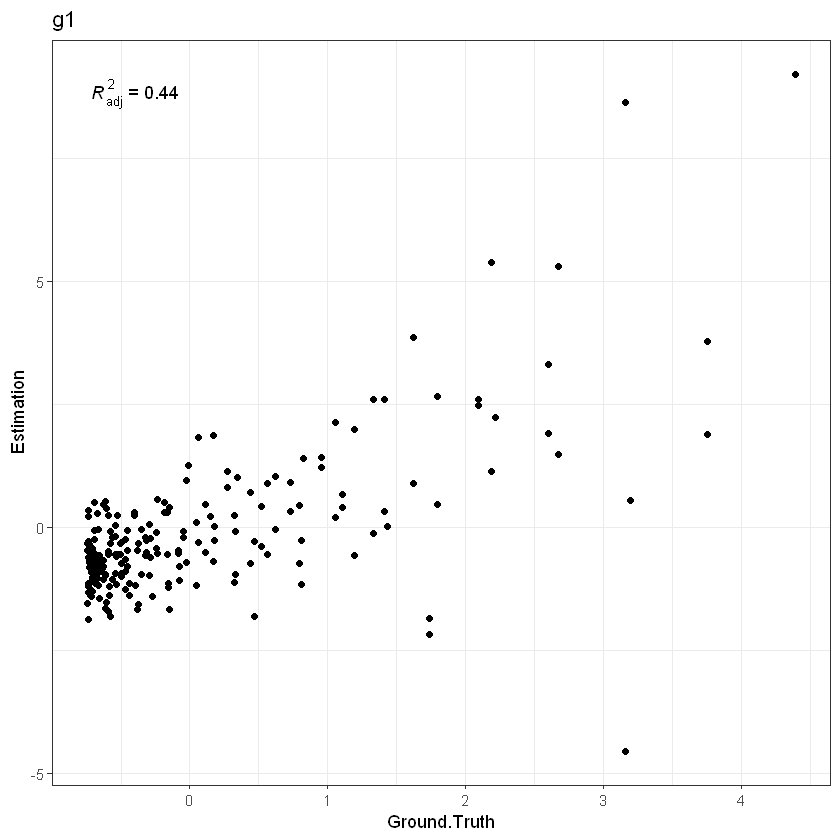

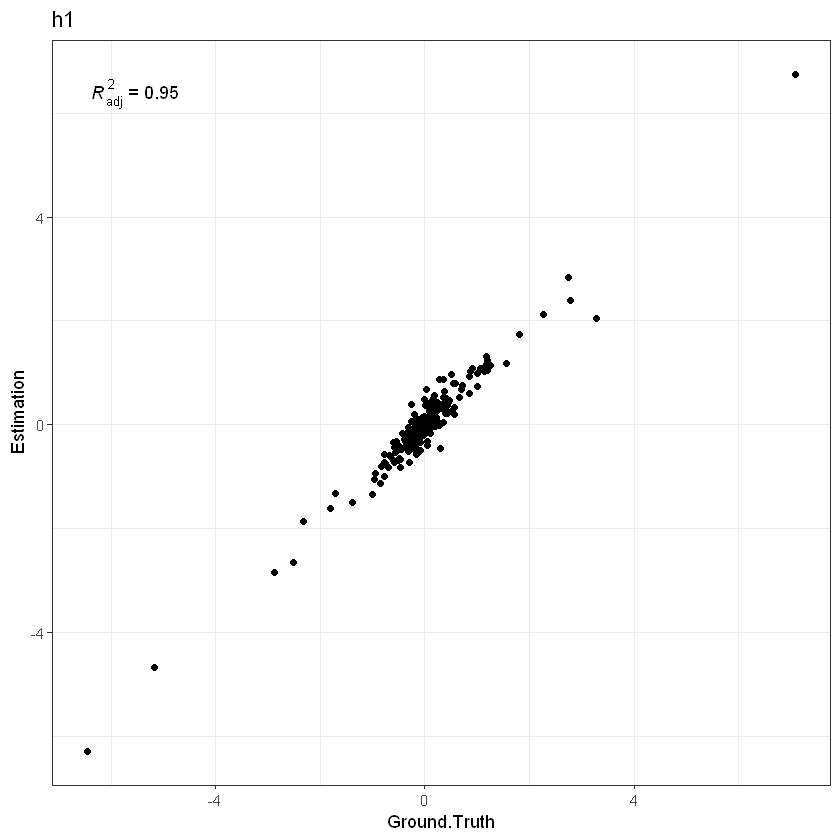

In [33]:
data.group <- read.csv("../data/hlm_group.csv", header = F)[[1]] + 1
hlm_data = cbind(
    read.csv("../data/hlm_y.csv", header = F),
    read.csv("../data/hlm_g.csv", header = F)[data.group,-1],
    read.csv("../data/hlm_x.csv", header = F)[,-1],
    data.group
)
colnames(hlm_data) <- c("y", "g1", "h1", "h2", "group")
hlm_model <- lmerTest::lmer(y ~ g1 + h1 + h2 + (g1 + h1 | group), hlm_data)
# summary(hlm_model)
performance::r2(hlm_model)
hlm_beta <- coefficients(hlm_model)$group
colnames(hlm_beta)[1] <- "Intercept"
data.frame(Ground.Truth = beta0$Intercept, Estimation = hlm_beta$Intercept) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "Intercept") +
    theme_bw()
data.frame(Ground.Truth = beta0$g1, Estimation = hlm_beta$g1) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "g1") +
    theme_bw()
data.frame(Ground.Truth = beta0$h1, Estimation = hlm_beta$h1) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "h1") +
    theme_bw()

## HLMGWR

In [34]:
hlmgwr_beta <- t(read.csv("../data/hlmgwr_hat_beta.csv", header = F)[1])
hlmgwr_gamma <- read.csv("../data/hlmgwr_hat_gamma.csv", header = F)
hlmgwr_mu <- read.csv("../data/hlmgwr_hat_mu.csv", header = F)
hlmgwr_coef <- cbind(
    Intercept = hlmgwr_gamma[,1] + hlmgwr_mu[,1] + hlmgwr_beta[1],
    hlmgwr_gamma[-1],
    hlmgwr_mu[-1],
    hlmgwr_beta[-1]
)
colnames(hlmgwr_coef) <- c("Intercept", "g1", "h1", "h2")
head(hlmgwr_coef)

,Intercept,g1,h1,h2
,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7270961,-0.02429532,-0.5131118,0.9696604
2,-0.8733498,-0.02425463,0.5175644,0.9696604
3,-0.6839515,-0.02420583,-0.1423172,0.9696604
4,-0.4043307,-0.02430612,-0.7847053,0.9696604
5,-0.3863027,-0.02435054,-0.7231043,0.9696604
6,-0.4199830,-0.02446708,-0.2125807,0.9696604


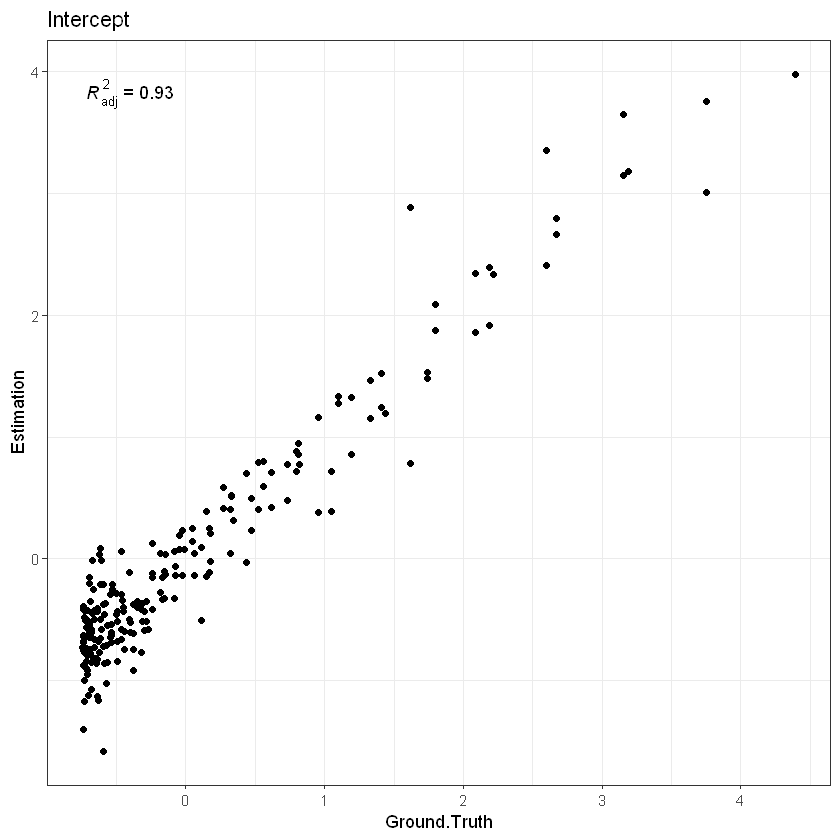

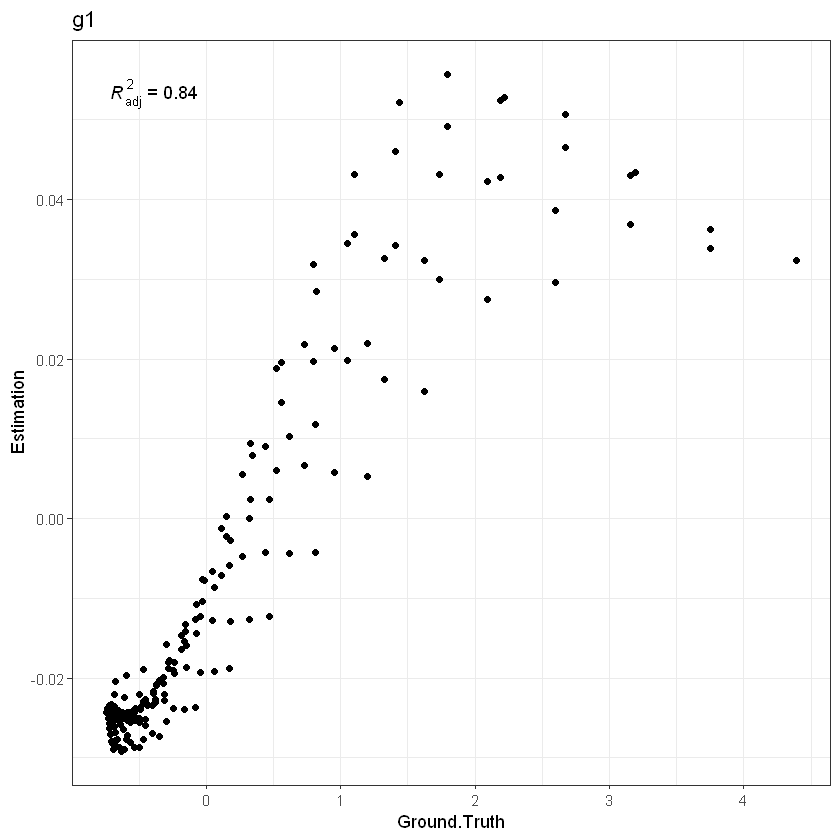

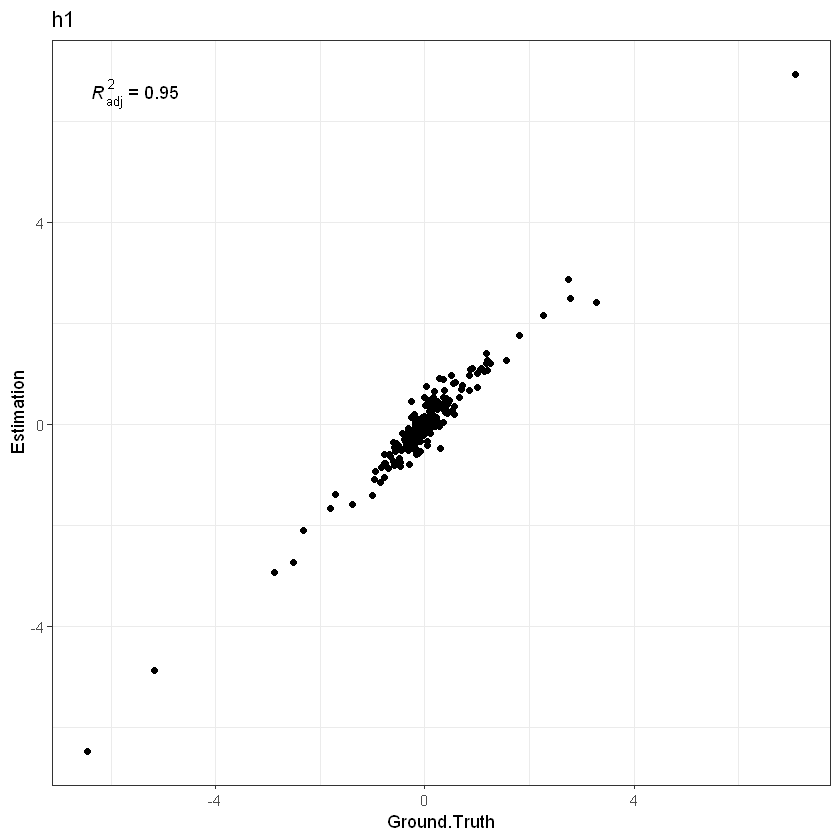

In [35]:
data.frame(Ground.Truth = beta0$Intercept, Estimation = hlmgwr_coef$Intercept) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "Intercept") +
    theme_bw()
data.frame(Ground.Truth = beta0$g1, Estimation = hlmgwr_coef$g1) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "g1") +
    theme_bw()
data.frame(Ground.Truth = beta0$h1, Estimation = hlmgwr_coef$h1) %>%
    ggplot(aes(Ground.Truth, Estimation)) +
    geom_point() +
    stat_poly_eq(aes(label = paste(..adj.rr.label..)), formula = y ~ x, parse = T) +
    # coord_fixed() + 
    labs(title = "h1") +
    theme_bw()

In [37]:
data.frame(
    HLM = c(mean(abs(beta0$Intercept - hlm_beta$Intercept) / beta0$Intercept),
            mean(abs(beta0$g1 - hlm_beta$g1) / beta0$g1),
            mean(abs(beta0$h1 - hlm_beta$h1) / beta0$h1),
            mean(abs(beta0$h2 - hlm_beta$h2) / beta0$h2)),
    HLMGWR = c(mean(abs(beta0$Intercept - hlmgwr_coef$Intercept) / beta0$Intercept),
               mean(abs(beta0$g1 - hlmgwr_coef$g1) / beta0$g1),
               mean(abs(beta0$h1 - hlmgwr_coef$h1) / beta0$h1),
               mean(abs(beta0$h2 - hlmgwr_coef$h2) / beta0$h2)),
    row.names = c("Intercept", "g1", "h1", "h2")
)

,HLM,HLMGWR
,<dbl>,<dbl>
Intercept,-0.23383377,-0.24995683
g1,-0.90381580,-0.33325106
h1,-0.77105993,-0.80237245
h2,0.02986479,0.03033956


In [38]:
data.frame(
    HLM = c(mean((beta0$Intercept - hlm_beta$Intercept)^2),
            mean((beta0$g1 - hlm_beta$g1)^2),
            mean((beta0$h1 - hlm_beta$h1)^2),
            mean((beta0$h2 - hlm_beta$h2)^2)),
    HLMGWR = c(mean((beta0$Intercept - hlmgwr_coef$Intercept)^2),
               mean((beta0$g1 - hlmgwr_coef$g1)^2),
               mean((beta0$h1 - hlmgwr_coef$h1)^2),
               mean((beta0$h2 - hlmgwr_coef$h2)^2)),
    row.names = c("Intercept", "g1", "h1", "h2")
)

,HLM,HLMGWR
,<dbl>,<dbl>
Intercept,0.0782525803,0.0779075727
g1,1.2310474299,0.9545054986
h1,0.0513430019,0.0510120598
h2,0.0008919059,0.0009204888


In [32]:
data.frame(index = 1:length(hlmgwr_coef$g1), hlmgwr = hlmgwr_coef$g1, real = beta0$g1, err = abs(beta0$g1 - hlmgwr_coef$g1))
data.frame(index = 1:length(hlmgwr_coef$g1), hlm = hlm_beta$g1, real = beta0$g1, err = abs(beta0$g1 - hlm_beta$g1))

index,hlmgwr,real,err
<int>,<dbl>,<dbl>,<dbl>
1,-0.02429531,-0.7419222,0.7176269
2,-0.02425463,-0.7408616,0.7166069
3,-0.02420582,-0.7392706,0.7150647
4,-0.02430612,-0.7371492,0.7128431
5,-0.02435053,-0.7344975,0.7101470
6,-0.02446707,-0.7313155,0.7068484
7,-0.02456163,-0.7276031,0.7030415
8,-0.02467008,-0.7233604,0.6986904
9,-0.02481602,-0.7185874,0.6937714


index,hlm,real,err
<int>,<dbl>,<dbl>,<dbl>
1,-0.3298724,-0.7419222,0.41204984
2,-1.5608115,-0.7408616,0.81994993
3,-0.6239805,-0.7392706,0.11529004
4,0.3475561,-0.7371492,1.08470526
5,0.2095542,-0.7344975,0.94405167
6,-0.3529821,-0.7313155,0.37833343
7,-0.7104648,-0.7276031,0.01713833
8,-0.4737766,-0.7233604,0.24958384
9,-0.7599856,-0.7185874,0.04139816
